In [2]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import re
import time
import pickle
pd.set_option('display.max_colwidth', 200)

# ELMo Language Model

The ELMo Language model constists of the following componenets:
- The model inputs a sequence of words
- Each word is broken down into their respective characters, where each caracter is then one-hot encoded to form a sparse matrix for every word.
- Each matrix is then multiplied by a learned embedding matrix to reduce the dimentionality into a dense character matrix
- The dense character matrix is then input into a CNN to generate a character-level representation of each of the words in the input sequence
- The character-level representations are then input into the 2 bi-directional LSTM layers, to process the input sequence both forwards and backwards
- The outputs for each layer is then concatinated and using to get a weighted average of the input embeddings
- Final contextualized word embeddings are then obtained the weighted average of the input words with the original word embeddings (those generated with the learned embedding matrix)

The use of the CNN over the character matrix allows the model to capture more nuanced relations between characters and words, as well as to be able to process out-of-vocabulary words. After this, the bidirectional language model allows the words in the input sequence to gain context from both directions, rather than just forward. Overall, these components allows the model to capture more complex linguistic phenomena and it has shown through various benchmarks to outperform almost all other existing models at the time.

## Problem Statement

In this notebook I will create a genre classifier model for poems in order to showcase ELMo using PyTorch. The dataset can be found [here](https://www.kaggle.com/datasets/ramjasmaurya/poem-classification-nlp)

## Dataset Description

The dataset that I am using for this project and analysis contains around 1000 poems, each being categorized into one of four genres: Affection, Environment, Music, and Death. The dataset consists of a total of 2 columns: the poem text its respective genre. The poems and their genre were obtained by scraping the website www.poets.org using the BeautifulSoup python library. There is potential to continue this effort to scrape possibly more data and expand the dataset. 

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

df_train = pd.read_csv("data/poem_train.csv")
df_test = pd.read_csv("data/poem_test.csv")

print(df_test.shape)
print("========")
print(df_train.head())
# sns.countplot(train['Genre'])
# plt.show()

(150, 2)
   Genre  \
0  Music   
1  Music   
2  Music   
3  Music   
4  Music   

                                                                                                                                                                                                      Poem  
0                                                                                                                                                                                                      NaN  
1                In the thick brushthey spend the hottest part of the day,              soaking their hoovesin the trickle of mountain water              the ravine hoardson behalf of the oleander.  ...  
2             Storms are generous.                                      Something so easy to surrender to, sitting by the window, and then you step out into the garden you were so bored of,               
3   —After Ana Mendieta Did you carry around the matin star? Did you hold forest-fire in one hand?

In [50]:
print("Training Data: \n")
print(df_train.info(), end="\n\n")
print("Testing Data: \n")
print(df_test.info())

Training Data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   841 non-null    object
 1   Poem    837 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB
None

Testing Data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   150 non-null    object
 1   Poem    150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB
None


## Data Quality

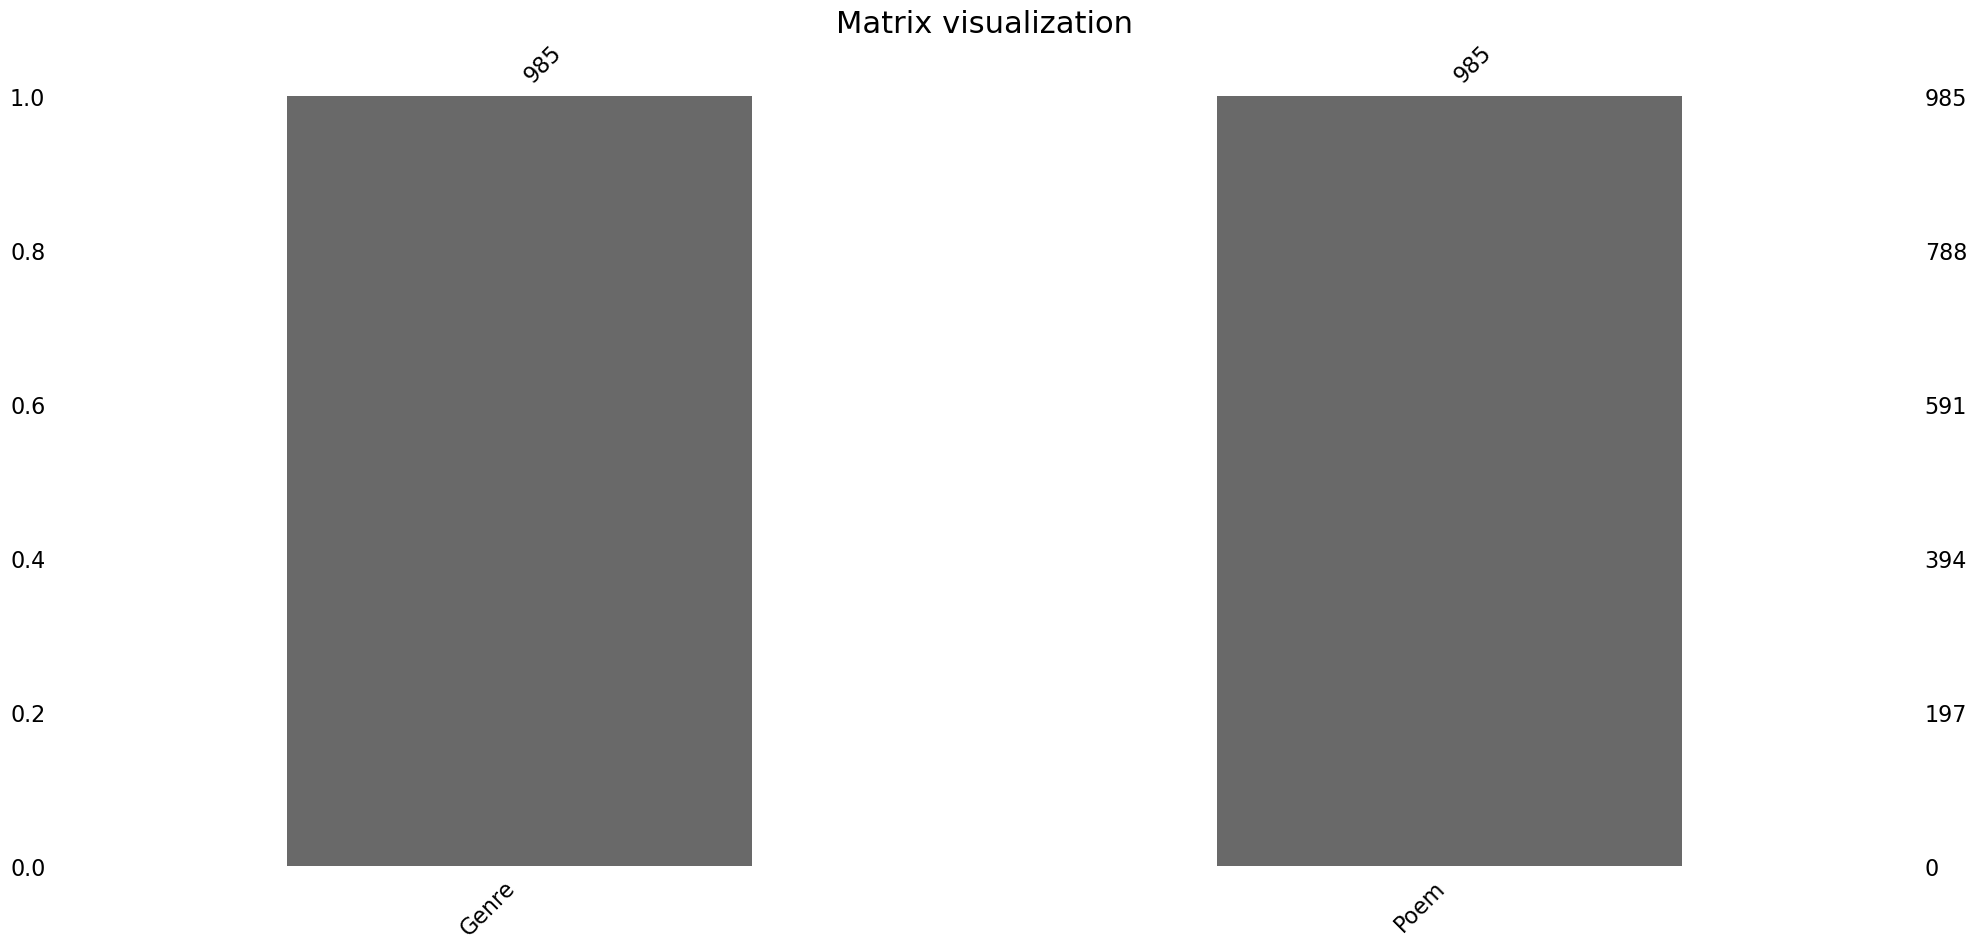

In [89]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

import missingno as mn
mn.bar(pd.concat([df_test, df_train]))
# plt.figure()
# mn.matrix(df.sort_values("Arrival Delay in Minutes"))
plt.title("Matrix visualization", fontsize=22)
plt.show()

There seem to be 4 null values within the dataset. I decided to just drop the NaN instances from the training set, as there is a small amount, and there aren't any ways I know of to impute extended text. 

In [51]:
print("{:.2%}".format(len(df_train[df_train["Poem"].isna()])/len(df_train)))
df_train[df_train["Poem"].isna()].describe()

0.48%


,Genre,Poem
count,4,0
unique,2,0
top,Death,NaN
freq,3,NaN


In [58]:
df_train = df_train[df_train["Poem"].isna() == False]

Now lets check for duplicate values, just in case. 

In [80]:
idx = df_train.duplicated()
print("Diplicates in training set: ", len(df_train[idx]))
df_train = df_train[-idx]

idx = df_test.duplicated()
print("Duplicates in test set: ", len(df_test[idx]))
df_test = df_test[-idx]

Diplicates in training set:  0
Duplicates in test set:  0


There were a couple of duplicates in the train set, to my surpise. This must have been a result of a small bug when scraping the data. Either way, I just removed the instances. 

Next, lets see how balanced each of the classes are in the dataset. Like most datasets regarding classifying genre, I expect there to be a large imbalance towards one genre. 

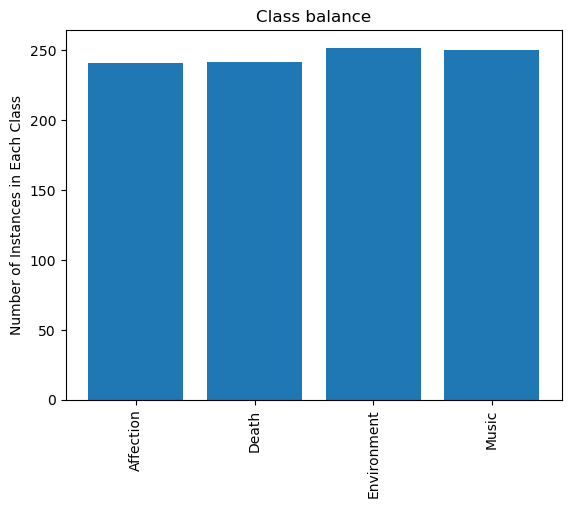

In [92]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 4

# print some stats of the data
df = pd.concat([df_test, df_train])
unique, counts = np.unique(df['Genre'], return_counts=True)

idx = [0,1,2,3] # indexes so the instance counts are in order from extremely negative to extremely positive
plt.bar(list(range(NUM_CLASSES)),counts[idx])
plt.xticks(list(range(NUM_CLASSES)), unique[idx], rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.title("Class balance")
plt.show()

Surprisingly, the dataset is extremely balanced, as each class only varies by ±10 instances. However, since the dataset is quite small, using K-folds to validate the model might still be necessary in training the model. 

## Text Processing and Cleaning

I will experiment with different preprocessing techniques to see how impactful stemming and removing stop words will be. At first, I will just remove punctuation marks, convert text to lowercase, and remove whitespace for basic cleaning

In [ ]:
import nltk

In [ ]:
# remove punctuation marks
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'

train['clean_tweet'] = train['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase
train['clean_tweet'] = train['clean_tweet'].str.lower()
test['clean_tweet'] = test['clean_tweet'].str.lower()

# remove numbers
train['clean_tweet'] = train['clean_tweet'].str.replace("[0-9]", " ")
test['clean_tweet'] = test['clean_tweet'].str.replace("[0-9]", " ")

# remove whitespaces
train['clean_tweet'] = train['clean_tweet'].apply(lambda x:' '.join(x.split()))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: ' '.join(x.split()))